<a href="https://colab.research.google.com/github/sakamunek/op_movie/blob/main/openpose02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pose Detection with OpenPose

This notebook uses an open source project [CMU-Perceptual-Computing-Lab/openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git) to detect/track multi person poses on a given video.

Please read the [OpenPose license](https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/LICENSE) before running this script.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
OPENPOSE_PATH="/content/drive/MyDrive/Colab Notebooks/openpose/"
HOME_PATH='/content/openpose/'

In [3]:
!echo $OPENPOSE_PATH
!echo $HOME_PATH

/content/drive/MyDrive/Colab Notebooks/openpose/
/content/openpose/


##Install OpenPose

In [4]:
#@title
!pip install ffmpeg-python
from os.path import exists, join, basename, splitext

def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))


# see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
# install new CMake becaue of CUDA10
!wget -q https://cmake.org/files/v3.17/cmake-3.17.2-Linux-x86_64.tar.gz
!tar xfz cmake-3.17.2-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local

# install system dependencies
!apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
!rm -rf openpose
# clone openpose
!git clone -q --depth 1 $git_repo_url
# --recursive necessary in the line below, as otherwise you can (sometimes) get "lpthreads" errors in cmake ("undefined reference to `pthread_create'" etc). See, for example, https://github.com/facebookarchive/caffe2/issues/1234
!sed -i 's/execute_process(COMMAND git checkout --recursive master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
!cd openpose && git submodule update --init --recursive --remote

Selecting previously unselected package liblmdb0:amd64.
(Reading database ... 123623 files and directories currently installed.)
Preparing to unpack .../00-liblmdb0_0.9.24-1build2_amd64.deb ...
Unpacking liblmdb0:amd64 (0.9.24-1build2) ...
Selecting previously unselected package libgflags2.2.
Preparing to unpack .../01-libgflags2.2_2.2.2-2_amd64.deb ...
Unpacking libgflags2.2 (2.2.2-2) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../02-libgflags-dev_2.2.2-2_amd64.deb ...
Unpacking libgflags-dev (2.2.2-2) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../03-libgoogle-glog0v5_0.5.0+really0.4.0-2_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.5.0+really0.4.0-2) ...
Selecting previously unselected package libunwind-dev:amd64.
Preparing to unpack .../04-libunwind-dev_1.3.2-2build2.1_amd64.deb ...
Unpacking libunwind-dev:amd64 (1.3.2-2build2.1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to un

Workaround for server problem (run if you see `file DOWNLOAD HASH mismatch` when building OpenPose):

In [5]:
!cp "/content/drive/MyDrive/models.zip" /content

In [6]:
#@title
# Workaround for server connection problem ("file DOWNLOAD HASH mismatch"),see, e.g.,
# https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/1602#issuecomment-641653411
!apt-get install unzip

# !wget -O models.zip  --no-check-certificate -r 'https://drive.google.com/uc?id=1QCSxJZpnWvM00hx49CJ2zky7PWGzpcEh&export=download'
!unzip -o models.zip -d openpose

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Archive:  models.zip
 extracting: openpose/models/pose/coco/pose_iter_440000.caffemodel  
 extracting: openpose/models/pose/coco/main.html  
 extracting: openpose/models/pose/mpi/pose_iter_160000.caffemodel  
 extracting: openpose/models/pose/body_25/pose_iter_584000.caffemodel  
 extracting: openpose/models/pose/body_25/training_results_source.txt  
 extracting: openpose/models/pose/body_25/training_log.txt  
   creating: openpose/models/pose/body_21a_video/
 extracting: openpose/models/pose/body_21a_video/pose_deploy.prototxt  
 extracting: openpose/models/pose/body_21a_video/pose_iter_264000.caffemodel  
   creating: openpose/models/pose/1_25BSuperModel11FullVGG/
   creating: openpose/models/pose/1_25BSuperModel11FullVGG/body_25b/
 extracting: openpose/models/pose/1_25BS

In [7]:
# use 'sed' to comment out the line in the OpenPose repo that downloads the model from the failed link
! sed -i 's/executeShInItsFolder "getModels.sh"/# executeShInItsFolder "getModels.sh"/g' ./openpose/scripts/ubuntu/install_openpose_JetsonTX2_JetPack3.1.sh
! sed -i 's/executeShInItsFolder "getModels.sh"/# executeShInItsFolder "getModels.sh"/g' ./openpose/scripts/ubuntu/install_openpose_JetsonTX2_JetPack3.3.sh
! sed -i 's/download_model("BODY_25"/# download_model("BODY_25"/g' ./openpose/CMakeLists.txt
! sed -i 's/78287B57CF85FA89C03F1393D368E5B7/# 78287B57CF85FA89C03F1393D368E5B7/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("body (COCO)"/# download_model("body (COCO)"/g' ./openpose/CMakeLists.txt
! sed -i 's/5156d31f670511fce9b4e28b403f2939/# 5156d31f670511fce9b4e28b403f2939/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("body (MPI)"/# download_model("body (MPI)"/g' ./openpose/CMakeLists.txt
! sed -i 's/2ca0990c7562bd7ae03f3f54afa96e00/# 2ca0990c7562bd7ae03f3f54afa96e00/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("face"/# download_model("face"/g' ./openpose/CMakeLists.txt
! sed -i 's/e747180d728fa4e4418c465828384333/# e747180d728fa4e4418c465828384333/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("hand"/# download_model("hand"/g' ./openpose/CMakeLists.txt
! sed -i 's/a82cfc3fea7c62f159e11bd3674c1531/# a82cfc3fea7c62f159e11bd3674c1531/g' ./openpose/CMakeLists.txt

In [8]:
! ls -lha /usr/lib/x86_64-linux-gnu

total 5.6G
drwxr-xr-x  1 root root  4.0K Nov  7 22:45 .
drwxr-xr-x  1 root root  4.0K Nov  6 14:19 ..
drwxr-xr-x  2 root root  4.0K Nov  6 14:18 atlas
drwxr-xr-x  1 root root  4.0K Nov  6 14:18 audit
drwxr-xr-x  2 root root  4.0K Nov  6 14:18 avahi
drwxr-xr-x  2 root root  4.0K Nov 10  2023 bfd-plugins
drwxr-xr-x  2 root root  4.0K Nov  6 14:18 blas
drwxr-xr-x  2 root root  4.0K Nov  6 14:18 caca
drwxr-xr-x  3 root root  4.0K Nov  6 14:18 ceph
drwxr-xr-x  1 root root  4.0K Nov  7 22:45 cmake
-rw-r--r--  1 root root  1.8K May  6  2024 crt1.o
-rw-r--r--  1 root root  1.2K May  6  2024 crti.o
-rw-r--r--  1 root root   760 May  6  2024 crtn.o
drwxr-xr-x  2 root root  4.0K Nov  6 14:18 dri
drwxr-xr-x  2 root root  4.0K Oct  4  2023 e2fsprogs
drwxr-xr-x  1 root root  4.0K Nov  6 14:18 engines-3
drwxr-xr-x  4 root root  4.0K Nov  6 14:18 fortran
drwxr-xr-x  1 root root   12K Nov  6 14:18 gconv
-rw-r--r--  1 root root  2.5K May  6  2024 gcrt1.o
drwxr-xr-x  2 root root  4.0K Nov  6 14:18 gdalpl

In [9]:
# build openpose
# CUDA
# !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. -DUSE_CUDNN=OFF && make -j`nproc`
#!cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
# CPU
# !cd openpose && rm -rf build || true && mkdir build && cd build && cmake -DGPU_MODE=CPU_ONLY -DUSE_MKL=OFF .. && cmake --build . --config Release && make -j`nproc`

!cd openpose && rm -rf build || true && mkdir build

In [10]:
cmake_file='/content/openpose/CMakeLists.txt'
!cd openpose && sed -i 's/-DBUILD_python=OFF/-DBUILD_python=ON/g' $cmake_file
!cd openpose && sed -i 's/-DBUILD_python_layer=OFF/-DBUILD_python_layer=ON/g' $cmake_file

!cd openpose && sed -i 's/option(BUILD_PYTHON "Build OpenPose python." OFF)/option(BUILD_PYTHON "OpenPose python." ON)\noption(BUILD_BIN_FOLDER "Copy 3rd-party DLL files." ON)/g' $cmake_file

In [11]:
# CUDA
!cd openpose && cd build && cmake .. -DUSE_CUDNN=OFF -DGENERATE_PYTHON_BINDINGS:BOOL="1" -DPYTHON_LIBRARY='/usr/lib/x86_64-linux-gnu/libpython3.10.so' && make -j`nproc`

 # CPU
# !cd openpose && cd build && cmake .. -DGPU_MODE=CPU_ONLY -DUSE_MKL=OFF -DGENERATE_PYTHON_BINDINGS:BOOL="1" -DPYTHON_LIBRARY='/usr/lib/x86_64-linux-gnu/libpython3.10.so'
# !cd openpose && cd build && make -j`nproc`

-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc - works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ - works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- GCC detected, adding compile flags
-- GCC detected, adding compile flags
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE  
-- Found CUDA: /usr/local/cuda (found version "12.2") 
-- Building with CUDA.
-- CUDA detected: 12.2
-- Added CUDA NVCC flags for: sm_75
-- Found cuDNN

## Try on YouTube video

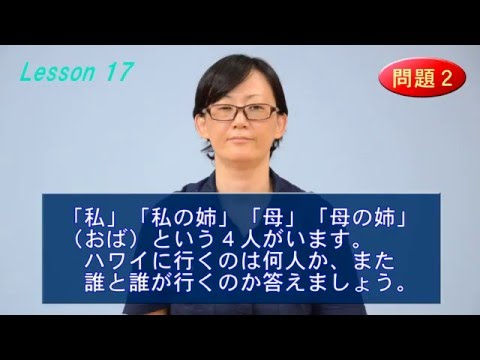

In [12]:
from IPython.display import YouTubeVideo
YOUTUBE_ID = 'yaMuEAARlsk'
YouTubeVideo(YOUTUBE_ID)

Download the above youtube video, cut and do the pose detection on that section:

In [13]:
# ! sudo -H pip install --upgrade youtube-dl
! pip install --upgrade --force-reinstall "git+https://github.com/ytdl-org/youtube-dl.git"

  Cloning https://github.com/ytdl-org/youtube-dl.git to /tmp/pip-req-build-pkom7m_2
  Running command git clone --filter=blob:none --quiet https://github.com/ytdl-org/youtube-dl.git /tmp/pip-req-build-pkom7m_2
  Resolved https://github.com/ytdl-org/youtube-dl.git to commit c5098961b04ce83f4615f2a846c84f803b072639
  Preparing metadata (setup.py) ... done
  Created wheel for youtube_dl: filename=youtube_dl-2021.12.17-py2.py3-none-any.whl size=1969896 sha256=cf1459af060571a0d675f0f89c4f06f19a58050d704debb39957797fde1756d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-5efau0ru/wheels/64/8e/40/866e846163e3e4859bbe820ff8847ec97f4320864f1525aa9a
Successfully built youtube_dl


In [14]:
# cut the video
!ffmpeg -y -loglevel info -i /content/drive/MyDrive/youtube.mp4 -ss 1 -t 110 video.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [27]:
# detect poses on the these 5 seconds
!cd $HOME_PATH && rm ../openpose.avi
!cd $HOME_PATH && chmod -R 755 './build/'
!cd $HOME_PATH && ./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi --face
# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

rm: cannot remove '../openpose.avi': No such file or directory
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 648.957791 seconds.
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable


Finally, visualize the result:

In [28]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)


## Download the detected video

In [29]:
# ダウンロードしたいフォルダを zip 圧縮する
!zip -r /content/keypoints.zip /content/openpose/output

  adding: content/openpose/output/ (stored 0%)
  adding: content/openpose/output/video_000000001825_keypoints.json (deflated 56%)
  adding: content/openpose/output/video_000000001778_keypoints.json (deflated 57%)
  adding: content/openpose/output/video_000000000894_keypoints.json (deflated 54%)
  adding: content/openpose/output/video_000000001087_keypoints.json (deflated 56%)
  adding: content/openpose/output/video_000000000637_keypoints.json (deflated 70%)
  adding: content/openpose/output/video_000000000553_keypoints.json (deflated 68%)
  adding: content/openpose/output/video_000000002159_keypoints.json (deflated 75%)
  adding: content/openpose/output/video_000000000085_keypoints.json (stored 0%)
  adding: content/openpose/output/video_000000002759_keypoints.json (deflated 54%)
  adding: content/openpose/output/video_000000001806_keypoints.json (deflated 56%)
  adding: content/openpose/output/video_000000000801_keypoints.json (deflated 55%)
  adding: content/openpose/output/video_000

In [30]:
# 圧縮した zip ファイルをダウンロードする
from google.colab import files
files.download("/content/keypoints.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>